## 8-2. グローバーのアルゴリズム

グローバーのアルゴリズムは、整列化されていないデータベースから特定のデータを探索するための量子アルゴリズムである[1]。
グローバーのアルゴリズムは、ソートされていない $N$ 個のデータに対して、$O( \sqrt{N})$ 回のクエリ（オラクルを呼ぶこと）で解を見出せる。古典コンピュータでは$O(N)$回のクエリが必要であるので、量子アルゴリズムを用いることで二次 (quadratic) の加速が実現されることになる。

オラクルさえ構成できれば、グローバーのアルゴリズムはあらゆる古典アルゴリズムの全探索部分を高速化することができる。例えば、

- 充足可能性問題（SAT問題）
- 特定のハッシュ値から元の値を探索する問題

といった応用例が考えられ、後者は実際にビットコインのマイニング高速化として提案論文がある[2]。

この節ではまずグローバーのアルゴリズムの理論的な説明を行い、その後 Qulacs による実装例を紹介する。

### アルゴリズムの流れ
グローバーのアルゴリズムの流れはシンプルで、以下の通りである。
前節と同様、 $N$ 個の要素からなるデータベースから $M$ 個の解を探索する問題を考え、要素のラベルを $n$ 桁のビット列 $x = x_1 \ldots x_n$ とする。

1. 全ての状態の重ね合わせ状態 $|s\rangle = \frac{1}{\sqrt{N}}\sum_x |x\rangle$ を用意する
2. オラクル $U_w$ （解に対する反転操作）を作用させる
3. $|s\rangle$ を対称軸にした反転操作 $U_s$ を作用させる
4. ステップ 2,3 を $k$ 回繰り返す
5. 測定を行う

各ステップを詳細に見ていこう。

#### 1. 全ての状態の重ね合わせ状態 $|s\rangle = \frac{1}{\sqrt{N}}\sum_x |x\rangle$ を用意する
これは簡単である。初期状態 $|0\cdots0\rangle$ に対して全ての量子ビットにアダマールゲート $H$ をかければ良い。

$$
 (H\otimes \cdots \otimes H) |0\cdots0\rangle = \frac{1}{(\sqrt{2})^n} (|0\rangle+|1\rangle) \otimes \cdots \otimes (|0\rangle+|1\rangle)
 = |s\rangle
$$


#### 2. オラクル $U_w$ （解に対する反転操作）を作用させる
次に、オラクルを状態 $|s\rangle$ に作用させる。
ここではオラクルとして、[前節](8.1_oracle.ipynb)の最後で述べたような「入力 $|x\rangle$  に対して $x$が解なら(-1)をかけて位相を反転し、解でないなら何もしない」という演算を考えることにして、補助ビットは省略する。つまり、オラクル $U_w$ を

$$
 U_w = I - 2\sum_{w\in \text{解}}|w\rangle \langle w|,  
$$

$$
 U_w|x\rangle =  
\begin{cases}
 |x\rangle  \:\: \text{(x is not solution)} \\
 -|x\rangle \:\: \text{(x is solution)}
\end{cases}
$$

と定義する。入力が解である時にだけ位相を反転させるので、オラクル $U_w$ は「解に対する反転操作」と呼ばれる。

#### 3. $|s\rangle$ を対称軸にした反転操作 $U_s$ を作用させる
ステップ2では解に対する反転操作を考えたが、ステップ3では全ての状態の重ね合わせ $|s\rangle$ を対称軸にした反転操作 $U_s$ を作用させる。

$$
 U_s = 2 |s\rangle \langle s| - I
$$

この演算子は、入力状態 $|\psi\rangle = a|s\rangle + b|s_\perp\rangle$ （$|s_\perp\rangle$ は $|s\rangle$ に直交するベクトル）に対して

$$
 U_s|\psi\rangle =  a |s\rangle - b|s_\perp\rangle
$$

と作用し、$|s_\perp\rangle$ に比例する部分の位相だけを反転する。

#### 4. ステップ2,3 を $k$ 回繰り返す
上記の2つの反転操作 $U_w$ と $U_s$ を繰り返す。後で述べるが、およそ $O(\sqrt{N/M})$ 回の繰り返しを行えば、次のステップ5の測定で十分高い確率で解が得られる。つまり、オラクルを呼ぶ回数は $O(\sqrt{N})$ で良い。

#### 5. 測定を行う
ここまでのステップで状態は $(U_s U_w)^k | s \rangle$ となっている。 $k$ はステップ2,3の繰り返しの回数である。
後述するように実はこの状態は、解 $w$ に対応する状態 $|w\rangle$ の係数（の絶対値）のみが非常に大きくなっているので、計算基底で測定を行えば、高い確率で解 $w$ (ビット列) が得られる。


理屈を抜きにすれば、グローバーのアルゴリズムで行う操作はこれだけで、非常にシンプルである。

### 幾何学的な説明
次に、グローバーのアルゴリズムがなぜ上手くいくのか、幾何学的な説明を行う。（他にも係数の平均操作に着目する説明もあり、例えば[3]を参照してほしい。）

#### 二次元平面の定義
まず、次の2つの状態 $|\alpha\rangle, |\beta\rangle$ で張られる2次元平面を考える。

$$
|\alpha\rangle = \frac{1}{\sqrt{N-M}} \sum_{x \in {解ではない}} |x\rangle
$$

$$
|\beta\rangle = \frac{1}{\sqrt{M}}\sum_{x \in 解} |x\rangle
$$  

全ての状態の重ね合わせ状態 $|s\rangle$ は次のように表せるので、この2次元平面内のベクトルであることがわかる。

$$
|s\rangle = \sqrt{\frac{N-M}{N}} |\alpha\rangle + \sqrt{\frac{M}{N}} |\beta\rangle
$$

特に、$\cos{\frac{\theta}{2}} = \sqrt{\frac{N-M}{N}}, \sin{\frac{\theta}{2}} = \sqrt{\frac{M}{N}}$ を満たす角 $\theta$ を用いれば

$$
|s\rangle = \cos{\frac{\theta}{2}} |\alpha\rangle + \sin{\frac{\theta}{2}} |\beta\rangle
$$

とかける。これを図示すると、以下のようになる。
（なお、一般に探索問題においては $N \gg{} M$ であるから、 $\sqrt{M/N}$ は0に近く、$\theta$ は0に近い正の数になっていることが多い。）

![Grovers](figs/8/GroverReflection.png)

#### 2回の反転操作 $U_s U_w$ = 二次元平面内の回転 
この平面内で考えると、オラクル $U_w$ は $|\beta\rangle$ 軸に対する反転操作である（$U_w|\alpha\rangle =|\alpha\rangle, U_w|\beta\rangle = -|\beta\rangle$）。
よって、$U_w$ を作用させた後、$|s\rangle$ を対称軸とした反転 $U_s$ を作用させると、$|\alpha\rangle, |\beta\rangle$ 平面内で角度 $\theta$だけの回転が行われることになる。（図を見て考えると分かる）

グローバーのアルゴリズムでは $U_s U_w$ を $k$ 回繰り返すから、状態は $k$ 回回転し、測定直前には

$$
 (U_s U_w)^k |s\rangle = \cos{\frac{(2k+1)\theta}{2}} |\alpha\rangle + \sin{\frac{(2k+1)\theta}{2}} |\beta\rangle
$$

となっている。 $N \gg M$ の時 $\theta$ は0に近い正の数だったから、$|s\rangle$ に $U_s U_w$ を作用させるたびに、$|\alpha\rangle$ の係数が減って $|\beta\rangle$ の係数が増えることになる。
$|\beta\rangle$ は全ての解の状態の重ね合わせでできていたから、これはすなわち $(U_s U_w)^k |s\rangle$ を測定した時に解が出力される確率が高まることを意味する。

以上が、グローバーのアルゴリズムが解を上手く探索できる理由である。

#### 最適な $k$ の見積もり
最後に、$U_s U_w$ を作用させる回数 $k$ 、つまりオラクルを呼ぶ回数がどれくらいになるのか評価してみよう。
これが計算量を決めることになる。

$(U_s U_w)^k |s\rangle$ が $|\beta\rangle$ に最も近くなるのは $\frac{(2k+1)\theta}{2}$ が $\frac{\pi}{2}$ に近くなるとき、すなわち$k$ が

$$
 R = \text{ClosestInteger}\left( \frac{\pi}{2\theta} -\frac{1}{2} \right)
$$

の時である。ここで $\text{ClosestInteger}(\ldots)$ は $\ldots$ に最も近い整数を表す。
$R$の上限を評価しよう。 $\theta > 0$ について成り立つ式

$$
 \frac{\theta}{2} \geq  \sin \frac{\theta}{2} = \sqrt{\frac{M}{N}}
$$

を使うと、

$$
 R \leq \left( \frac{\pi}{2\theta} -\frac{1}{2} \right) + 1 = \frac{\pi}{2\theta} + \frac{1}{2} \leq \frac{\pi}{4}\sqrt{\frac{N}{M}} + \frac{1}{2}
$$

となる。つまり、$R$ は高々 $O(\sqrt{N/N})$ であり、グローバーのアルゴリズムが $O(\sqrt{N})$ で動作することが分かった。


### 実装例
グローバーのアルゴリズムを Qulacs を用いて実装してみよう。（実装コードは[4]をほぼそのまま使用している）

In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

In [2]:
## 係数の絶対値の分布をプロットする関数
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))], abs(state.get_vector()))
    plt.show()

#### 動作の確認
まずは 5 qubitでグローバーのアルゴリズムを実装し、動作を確認してみよう。
全ての状態の重ね合わせ状態 $|s\rangle$ は状態 $|0\cdots0\rangle$ の全てのビットにアダマールゲートを作用させることで作れる。

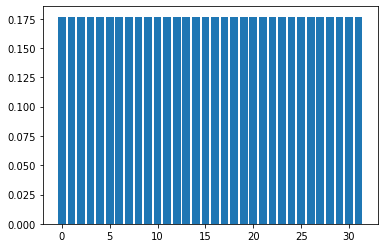

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state,nqubits)

次にオラクル $U_w$ を作る。ここでは $|1\ldots1\rangle$ を解として設定し、$|1\ldots1\rangle$ のみに位相(-1)をつける演算子を作る。
このような演算子は「`0`番目から`nqubits-1`番目までの量子ビットがすべて`1`の場合に`nqubits`番目の量子ビットに $Z$ ゲートを作用させる演算子」として実装できる。
実装には Qulacs の特殊ゲート `to_matrix_gate` を用い、 `control_index` と`control_with_value` を使用する。

In [4]:
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

オラクルの作用を確認すると、確かに最後の成分（$|1\cdots1\rangle$）だけ位相が反転していることが分かる。

In [5]:
hoge = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


同様に、$|s\rangle$ を対称軸にした反転 $U_s$ を作る。以下の式が成り立つことを使う。

$$
U_s = 2 |s\rangle \langle s| - I = H^{\otimes n} (2 |0\cdots0\rangle \langle0\cdots0| - I) H^{\otimes n}  
$$

In [6]:
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) ) 

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

それでは、 $U_s U_w$ を一回だけ作用させて確率分布の変化を見てみよう。全部1の状態（一番右側）の確率が少し大きくなっている。

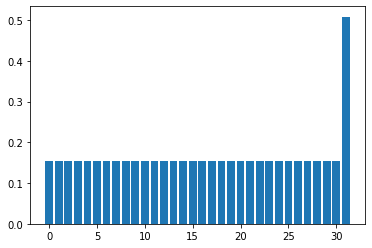

In [7]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

これを何回か繰り返してみると

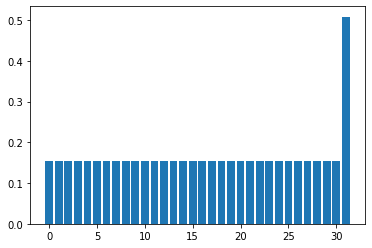

0.5082329989778305


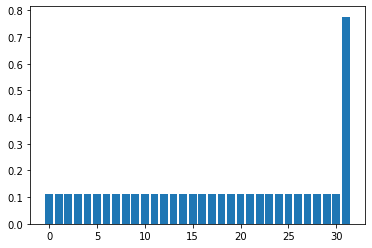

0.7761601777867947


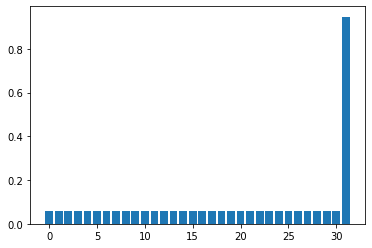

0.9470673343724091


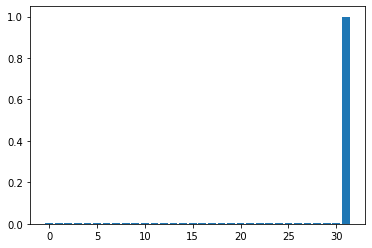

0.9995910741614723


In [8]:
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1 
    
## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

$k=4$ 回ほどの繰り返しで、ほぼ確率 1 で解の状態を得ることができた。
`nqubits` をもう少し大きくして、$k$ に対する解出力確率の振る舞いをチェックしてみる。

maximal probability 9.997306e-01 is obtained at k = 25


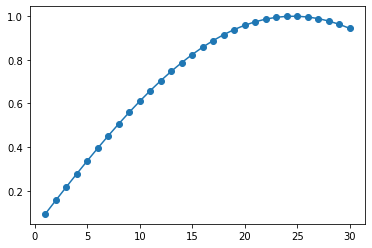

In [9]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1 
    
## グローバーのアルゴリズムの実行
Hadamard = make_Hadamard(nqubits)
U_w= make_U_w(nqubits)
U_s = make_U_s(nqubits)

result = []

state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)
for k in range(30):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    #show_distribution(state,nqubits)
    result.append(np.linalg.norm(inner_product(state, target_state)))

max_k = np.argmax(result)
print( f"maximal probability {result[max_k]:5e} is obtained at k = {max_k+1}")

plt.plot(np.arange(1, 30+1), result, "o-")

$k=25$ 回 でほぼ確率1でtarget状態が得られている。また、確率の$k$依存性は、「幾何学的な説明」の箇所で見たように、サイン関数になっている。

最後に、解を見つけるのに必要な $k$ が量子ビット数についてどのように振る舞うか見てみよう。

In [10]:
result = []
min_nqubits = 6
max_nqubits = 16
for nqubits in range(min_nqubits, max_nqubits+1, 2):
    ## 回路の準備
    Hadamard = make_Hadamard(nqubits)
    U_w= make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    ## 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1 

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)

    ## 確率が減少を始めるまで U_s U_w をかける
    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 and num_iter <= 1000:
        num_iter += 1
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else: 
            flag = 1
    result.append( [nqubits, num_iter, suc_prob] )
    print(f"nqubits={nqubits}, num_iter={num_iter}, suc_prob={suc_prob:5e}")

nqubits=6, num_iter=7, suc_prob=9.526013e-01
nqubits=8, num_iter=13, suc_prob=9.930691e-01
nqubits=10, num_iter=26, suc_prob=9.963280e-01
nqubits=12, num_iter=51, suc_prob=9.992534e-01
nqubits=14, num_iter=101, suc_prob=9.998851e-01
nqubits=16, num_iter=202, suc_prob=9.999368e-01


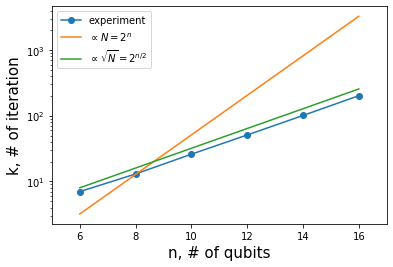

In [11]:
result_array = np.array(result)

plt.xlim(min_nqubits-1, max_nqubits+1)
plt.xlabel("n, # of qubits", fontsize=15)
plt.ylabel("k, # of iteration", fontsize=15)
plt.semilogy(result_array[:,0], result_array[:,1], "o-", label="experiment")
plt.semilogy(result_array[:,0], 0.05*2**result_array[:,0], "-", label=r"$\propto N=2^n$")
plt.semilogy(result_array[:,0], 2**(0.5*result_array[:,0]), "-", label=r"$\propto \sqrt{N}=2^{n/2}$")
plt.legend(fontsize=10)

繰り返し回数＝オラクルを呼ぶ回数 $k$ が $O(N)$ ではなく $O(\sqrt{N})$ に比例していることがわかる。

### 発展
興味のある読者は、グローバーのアルゴリズムを使ってコンビニの配置問題を解く [IBM Quantum Challenge 2019 コンテスト問題](https://github.com/quantum-challenge/2019/blob/master/problems/final/Final.ipynb) に取り組んでほしい。[解答例](https://github.com/quantum-challenge/2019/blob/master/problems/final/answer_and_comment_by_judges.ipynb)もアップロードされている。

### 参考文献

[1] M. A. Nielsen and I. L. Chuang, “Quantum Computation and Quantum Information 10th Anniversary Edition“, University Printing House の `6.1 The quantum search algorithm`   
[2] D. Aggarwal, G. Brennen, T. Lee, M. Santha, and M. Tomamichel, “Quantum Attacks on Bitcoin, and How to Protect Against Them“, Ledger, [S.l.], v. 3, oct. 2018, https://ledgerjournal.org/ojs/index.php/ledger/article/view/127   
[3] IBM Quantum Challenge 2019, Week 2 ノートブック https://github.com/quantum-challenge/2019/blob/master/problems/week2/week2.ipynb   
[4] 藤井啓祐, “グローバー探索量子アルゴリズムをとことん実装する“, https://github.com/keisukefujii/QulacsExamples/blob/master/GroverSearch.ipynb